In [6]:
import numpy as np
import matplotlib as mlt
import pandas as pd

In [7]:
myDf = pd.read_csv(r"C:\Users\yug\Desktop\Projects\AIML\housing.csv")
myDf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
myDf = myDf.dropna(how="any")
myDf = myDf.drop("ocean_proximity",axis=1)

In [9]:
myDf["income_category"] = np.ceil(myDf["median_income"]/1.5) #Ceiling returns rounded up integral value
#WE used < because it keeps original value when condition is true but changes the value when the condition is false.
myDf["income_category"].where(myDf["income_category"] < 5, 5.0, inplace=True)
#myDf["income_category"].value_counts()

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(myDf, test_size=0.2, random_state=42)

print(len(train_set), "train +", len(test_set), "test")    

16346 train + 4087 test


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

# splits only contains the indices for splitting data
splits = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splits.split(myDf, myDf["income_category"]):
    train_set = myDf.iloc[train_index]
    test_set = myDf.iloc[test_index]

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

<Figure size 6000x4000 with 0 Axes>

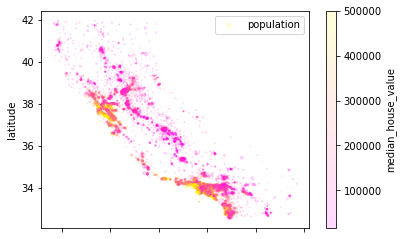

In [12]:
from matplotlib import pyplot
mlt.pyplot.figure(dpi=1000)
myDf.plot.scatter(x="longitude", y="latitude", alpha=0.15, s= myDf["population"]/1000, cmap="spring", c="median_house_value", label="population")

In [13]:
corrVals = myDf.corr()
corrVals["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688355
income_category       0.643941
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
population           -0.025300
longitude            -0.045398
latitude             -0.144638
Name: median_house_value, dtype: float64

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

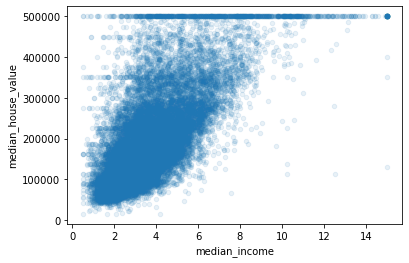

In [14]:
myDf.plot(kind="scatter", x= "median_income", y="median_house_value", alpha=0.1)

In [15]:

myDf["rooms_per_house"] = myDf["total_rooms"]/myDf["households"]
myDf["bedrooms_per_house"] = myDf["total_bedrooms"]/myDf["total_rooms"]

In [16]:
corrValues = myDf.corr()
corrValues["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688355
income_category       0.643941
rooms_per_house       0.151344
total_rooms           0.133294
housing_median_age    0.106432
households            0.064894
total_bedrooms        0.049686
population           -0.025300
longitude            -0.045398
latitude             -0.144638
bedrooms_per_house   -0.255880
Name: median_house_value, dtype: float64

In [17]:
# Reverting back to clean training set
myDf = train_set.drop("median_house_value", axis=1)
myDfLabels = train_set["median_house_value"].copy()
# For Test Set
testSet = test_set.drop("median_house_value", axis=1)
testLabels = test_set["median_house_value"].copy()
# For Training Set
trainSet = train_set.drop("median_house_value", axis=1)
trainLabels = train_set["median_house_value"].copy()

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

 #rowNo's of our attributes which we need to transform
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        roomRow, bedroomRow, populationRow, householdRow = [
            list(myDf.columns).index(col) for col in("total_rooms", "total_bedrooms", "population", "households")
        ]
        rooms_per_household = X[:, roomRow] / X[:, householdRow]
        population_per_household = X[:, populationRow] / X[:, householdRow]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroomRow] / X[:, roomRow]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [19]:
from sklearn.base import TransformerMixin, BaseEstimator

class DataFrameSelector():
    def __init__(self, attrNames):
        self.attrNames = attrNames

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.attrNames].values

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Imputer wasn't used as it is for ocean_proximity missing values(Which we deleted)
# A pipeline takes in a number of transformations with a final estimator at the end. (All transformers have a fit_transform() method.)
myPipeline = Pipeline([
    ("dfToNpArr", DataFrameSelector(list(myDf))),
    ("attr_adder", CombinedAttributesAdder()),
    ("std_scaler", StandardScaler())
])

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

myPrepDf = myPipeline.fit_transform(myDf)
linRegr = LinearRegression()
# Fit means to adjust parameters inside the dataset for accuracy
linRegr.fit(myPrepDf, myDfLabels)


myPreds = linRegr.predict(myPrepDf)

mse = mean_squared_error(myDfLabels, myPreds)
print(np.sqrt(mse))

68667.19485886578


In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

myPrepDf = myPipeline.fit_transform(myDf)

decTree = DecisionTreeRegressor()
decTree.fit(myPrepDf, myDfLabels)

myPreds = decTree.predict(myPrepDf)

mse = mean_squared_error(y_true= myDfLabels, y_pred= myPreds)
print(np.sqrt(mse))
# The 0 isn't a mistake. The model is simply completely overfitting the data.

0.0


In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(decTree, trainSet, trainLabels, scoring="neg_mean_squared_error", cv=10)
# This is taking trainSet and trainLabels, dividing them into 10(cv) subsets called folds and then trains decTree 10 times for all folds.
# This function expects a utility function(higher is better) instead of a cost function like MSE(lower is better). So, we use NMSE.

rmse_scores = np.sqrt(-scores)

def showScores(scores):
    print("Scores: ", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation: ", scores.std())

showScores(rmse_scores)

Scores:  [73275.3331834  67902.55573708 72746.76513074 68656.8130845
 69504.89496796 71887.98543024 69548.56664014 69701.33779294
 68602.74027766 75890.144513  ]
Mean: 70771.71367576769
Standard Deviation:  2434.5282085805475


In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

myPrepDf2 = myPipeline.fit_transform(myDf)

linRegr2 = LinearRegression()
linRegr2.fit(myPrepDf2, myDfLabels)

scores2 = cross_val_score(linRegr2, trainSet, trainLabels, cv=10,scoring="neg_mean_squared_error")
rmse_scores2 = np.sqrt(-scores2)

def showScores2(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Std_Dev: ", scores.std())

showScores2(rmse_scores2)

Scores:  [70130.43281797 65846.28902271 69497.11311775 71181.14174001
 67790.46787726 72707.67922655 75328.34434794 68731.21850326
 68248.14837026 69623.97935316]
Mean:  69908.48143768715
Std_Dev:  2534.9468788948925


In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

myPrepDf3 = myPipeline.fit_transform(myDf)

myRFC = RandomForestRegressor()
myRFC.fit(myPrepDf3, trainLabels)

RandomForestRegressor()

In [33]:
from sklearn.model_selection import GridSearchCV

print(myRFC._get_param_names())
parameterGrid = [
    {"n_estimators": [3,10,30], "max_features": [2,4,6,8]},
    {"bootstrap": [False], "n_estimators": [3,10], "max_features": [2,3,4]}
]
myRFC2 = RandomForestRegressor()

gridSearch = GridSearchCV(myRFC2, parameterGrid, cv=6, scoring="neg_mean_squared_error")
gridSearch.fit(myPrepDf3, myDfLabels)
gridSearch.best_params_

['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start']


{'max_features': 6, 'n_estimators': 30}

{'max_features': 6, 'n_estimators': 30}

In [ ]:
storedSearch = gridSearch